# FED's (Federal Reserve System) Actions Analysis

### Importing Monthly & Quarterly Data

In [ ]:
# Importing Data
import pandas as pd
import numpy as np
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

month_sheet = gc.open('Economic Indicators Dataset').sheet1
quarter_sheet = gc.open('Quarterly Data').sheet1

# get_all_values gives a list of rows.
month_data = month_sheet.get_all_values()
quarter_data = quarter_sheet.get_all_values()

# Convert to a DataFrame
# ASSIGN LABELS
# SEPARATE INTO X and Y
data = pd.DataFrame.from_records(month_data[1:], columns=['DATE', 'GDP', 'INDUSTRIAL PRODUCTION', 'PERSONAL CONSUMER EXPENDITURES', 'HOME SALES', 'CPI', 'EMPLOYED POPULATIONS', 'PERMITS', 'CLASS'])
X_month = data.iloc[:, 1:-1]
y_month = data['CLASS']
#X_month.head()
#y_month.head()

# Converting to DataFrame and Assigning labels
X_quarter_Year = pd.DataFrame.from_records(quarter_data[1:], columns=['Year', 'GDP', 'Industrial Production', 'Personal Consumer Expenditures', 'Home Sales', 'Building Permits', 'CPI', 'Employed Populations', 'Gini Index', 'Monetary Policy Uncertainty'])
X_quarter = pd.DataFrame(X_quarter_Year.iloc[:, 1:])
X_quarter["Gini Index"].replace("", np.nan, inplace=True)
X_quarter.dropna(subset=['Gini Index'], inplace=True)
#X_quarter.head()

### K-Nearest Neighbors: Monthly Data

In [ ]:
from sklearn.preprocessing import LabelEncoder

classes = set(y_month.to_numpy())
print(f'Set of classes: {classes}')

le = LabelEncoder()
le.fit(y_month)
y = le.transform(y_month)

Set of classes: {'Open Market Operations', 'Interest Rate Hike', 'No adjustment', 'Quantitative Easing', 'Interest Rates Lowered'}


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

clf_knn = KNeighborsClassifier(n_neighbors=3)
X_train, X_test, y_train, y_test = train_test_split(X_month, y, test_size=0.2, random_state=42)

clf_knn.fit(X_train, y_train)

# The accuracy of prediction
y_pred = clf_knn.predict(X_test)
print("Accuracy of Prediction: " + str(np.average(y_test == y_pred)))

Accuracy of Prediction: 0.9047619047619048


### Random Forest Classifier with K-Fold Cross-Validation: Monthly Data


In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier with K-Fold Cross-Validation
def rfc_kfold(X, y, k_fold=10):
  '''
  K-Fold Cross-Validation on Random Forest Classifier
  '''
  kfold = KFold(n_splits=k_fold, shuffle=True)
  splits = kfold.split(X)

  rfc = RandomForestClassifier(max_depth=7, random_state=0)
  rfc_results = []
  

  for i, split in enumerate(splits):
      train_idx, test_idx = split
      X_train = X.iloc[train_idx]
      y_train = y.iloc[train_idx]
      X_test = X.iloc[test_idx]
      y_test = y.iloc[test_idx]
    
      rfc.fit(X_train, y_train)
    
      # generate predictions and calculate accuracy
      rfc_pred = rfc.predict(X_test)
      rfc_acc = np.sum(rfc_pred == y_test) / len(y_test)
      rfc_results.append(rfc_acc)
    
      print('Test fold {} results:'.format(i + 1))
      print('\tRFC: {:.4f}'.format(rfc_acc))
    
  print('Average results:')
  print('\tRFC: {:.4f} +- {:.4f}'.format(np.mean(rfc_results), np.std(rfc_results)))

In [ ]:
# Random Forest Classifier on Monthly Data
rfc_kfold(X_month, y_month)

Test fold 1 results:
	RFC: 0.9375
Test fold 2 results:
	RFC: 0.8438
Test fold 3 results:
	RFC: 0.9375
Test fold 4 results:
	RFC: 0.8750
Test fold 5 results:
	RFC: 0.9375
Test fold 6 results:
	RFC: 0.9677
Test fold 7 results:
	RFC: 0.8710
Test fold 8 results:
	RFC: 0.9032
Test fold 9 results:
	RFC: 0.9032
Test fold 10 results:
	RFC: 0.9032
Average results:
	RFC: 0.9080 +- 0.0358


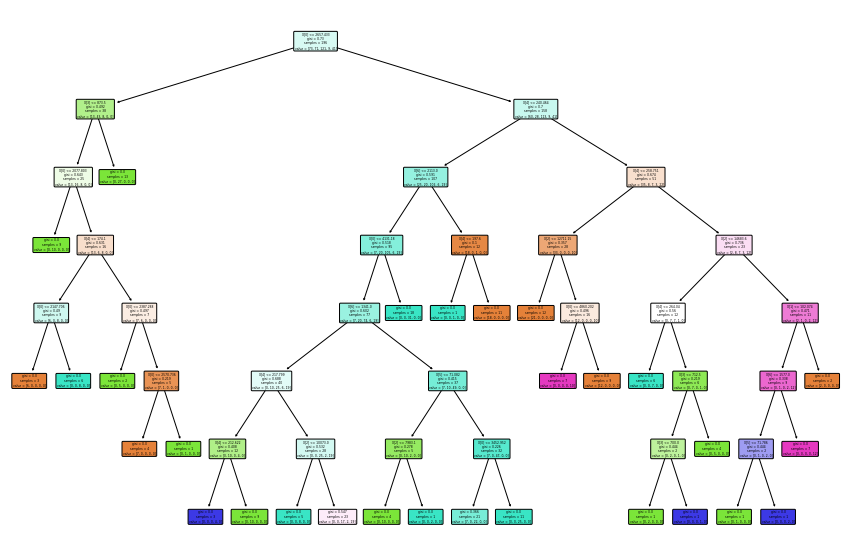

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

rf = RandomForestClassifier(max_depth=7, random_state=0)
rf.fit(X_month, y_month)

fig = plt.figure(figsize=(15, 10))
plot_tree(rf.estimators_[0],
          filled=True, impurity=True, 
          rounded=True)

# Save the picture
fig.savefig('random_forest.png')

### Interpretation of the Results
The above classification models (K-Nearest Neighbors and Random Forest Classifier) appear to be very efficient when predicting the action FED will take depending on the current standings of economy in the country.

### K-Means Clustering: Quarterly Data


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def kmeans_clustering(X, k):
  clustering = KMeans(n_clusters=k).fit(X)

  labels = clustering.labels_
  centroids = clustering.cluster_centers_
  u_labels = np.unique(labels)

  pd.DataFrame(centroids, columns=X.columns).T

  MeanSilhouetteCoefficient = round(silhouette_score(X_quarter, labels), k)
  print(f'The mean silhouette coefficient for {k} clusters: {MeanSilhouetteCoefficient}')

  return clustering

# Standardizing the data for PCA
X_quarter_pca = StandardScaler().fit_transform(X_quarter)

# PCA - Dimensionality Reduction
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_quarter_pca)
X_quarter_pca = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# mention which features it chose
print(abs( pca.components_ ))

for k in range(3, 10):
  kmeans_clustering(X_quarter_pca, k)

[[0.43811628 0.38922183 0.43890189 0.19137782 0.18385518 0.44155341
  0.26101702 0.3586323  0.04220186]
 [0.06282478 0.24959056 0.05741133 0.51061667 0.5106188  0.07030161
  0.38878927 0.26228189 0.42907971]]
The mean silhouette coefficient for 3 clusters: 0.502
The mean silhouette coefficient for 4 clusters: 0.4045
The mean silhouette coefficient for 5 clusters: 0.40186
The mean silhouette coefficient for 6 clusters: 0.392265
The mean silhouette coefficient for 7 clusters: 0.3646769
The mean silhouette coefficient for 8 clusters: 0.37521931
The mean silhouette coefficient for 9 clusters: 0.364723467


### Visualization: 8-Means Clustering

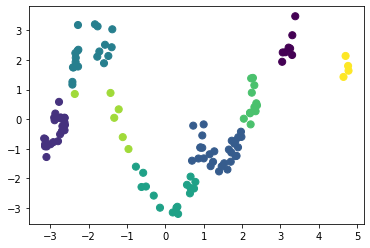

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

kmeans = KMeans(n_clusters=8)
kmeans.fit(X_quarter_pca)
kmeans = kmeans.predict(X_quarter_pca)

plt.scatter(X_quarter_pca.iloc[:, 0], X_quarter_pca.iloc[:, 1], c=kmeans, s=50, cmap='viridis')

### Hierarchical Clustering

In [ ]:
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering

# 2D embedding of the dataset
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X_quarter)

labels = []

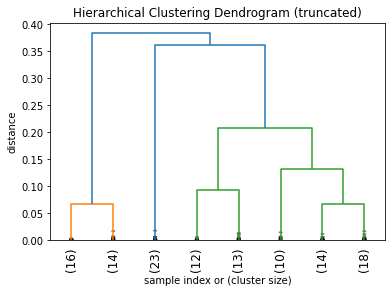

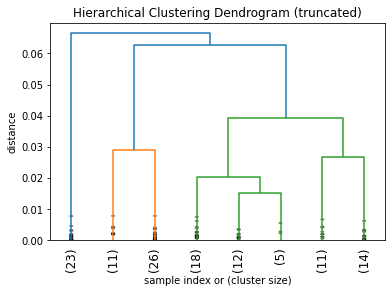

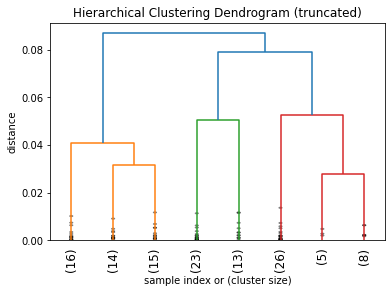

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_clustering(X, link): 

  Z = linkage(X, link)

  plt.title('Hierarchical Clustering Dendrogram (truncated)')
  plt.xlabel('sample index or (cluster size)')
  plt.ylabel('distance')
  dendrogram(
      Z,
      truncate_mode='lastp',  
      p=8,  
      leaf_rotation=90.,
      leaf_font_size=12.,
      show_contracted=True,  
  )
  plt.show()


for link in ('ward', 'average', 'complete'):
    clustering = AgglomerativeClustering(linkage=link, n_clusters=8)
    clustering.fit(X_red)
    labels.append(clustering.labels_)

    plot_clustering(X_red, link)

### Evaluation of Hierarchical Clustering

In [ ]:
# Evaluating the clustering using Silhouette Coefficient
from sklearn.metrics import silhouette_samples, silhouette_score

MeanSilhouetteCoefficient = round(silhouette_score(X_red, labels[0]), 2)
print("The mean silhouette coefficient for 'ward' Agglomerative Clustering: " + str(MeanSilhouetteCoefficient))

MeanSilhouetteCoefficient = round(silhouette_score(X_red, labels[1]), 2)
print("The mean silhouette coefficient for 'average' Agglomerative Clustering: " + str(MeanSilhouetteCoefficient))

MeanSilhouetteCoefficient = round(silhouette_score(X_red, labels[2]), 2)
print("The mean silhouette coefficient for 'complete' Agglomerative Clustering: " + str(MeanSilhouetteCoefficient))

The mean silhouette coefficient for 'ward' Agglomerative Clustering: 0.61
The mean silhouette coefficient for 'average' Agglomerative Clustering: 0.6
The mean silhouette coefficient for 'complete' Agglomerative Clustering: 0.61


### Interpretation of the Results
Both clustering models appear to be inefficient when used to predict FED's action, with hierarchical clustering being a little more successful than the K-means clustering model.
